<h1>Seattle Business Discount Partnerships Around Art</h1>

<h2 style="color:#00a2ed">Table of Contents</h2><a name="backtotop"></a>

<ul>
    <li><a href="#intro">Introduction</a></li>
    <li><a href="#data">Data</a></li>
    <li><a href="#method">Methodology</a></li>
    <li><a href="#results">Results & Discussion</a></li>
    <li><a href="#conclusion">Conclusion</a></li>
</ul>

<h2 style="color:#00a2ed">Introduction/Business Problem</h2><a name="intro"></a>

<p><b>Recommending business partnerships to increase traffic.</b></p>
<p><b>Problem:</b></p>
<p>Many businesses have been closed for multiple months and in dire need of revenue. They would benefit from a new way to draw customers to their business as customers look to return to a sense of normalcy and routine. By leveraging Foursquare venue data and Seattle Public Art data, I would like to investigate the proximity of related or behaviorally relevant businesses and public artwork in the Seattle area to look for partnership opportunities. One business could offer a discount with a receipt from the partner business.</p>
<p><b>Target Audience:</b></p>
<p>Small businesses located near public art installations and tourists. This could help businesses eager to re-open after shelter-in-place by creating a story/theme for those customers looking to get out of the house. Small businesses would care about this because it could offer a creative way to market to new/existing customers. Tourists would care about this because appreciating a city could include its public art and unique small businesses.</p>

<a href="#backtotop">Back to Top</a>

<h2 style="color:#00a2ed">The Data</h2><a name="data"></a>

<p>In order to tell a story around a piece of art, we will need its coordinates to pull Foursquare data in that area.</p>

<p><b>Starting Point:</b> A CSV file containing a list of <span style="color:#a90000">Seattle public art installations</span> and their latitude/longitude.</p>

<ul>
    <li>Title</li>
    <li>Description</li>
    <li>Art Latitude</li>
    <li>Art Longitude</li>
</ul>
    
<p><b>Primary Data:</b> <span style="color:#a90000">Foursquare Venues Data</span></p>

<p>We will call the Foursquare API to collect 10 venues within 250 meters around each art piece. Then, we'll use K-Means Clustering to aggregate the venues into 4 large regions. Each region will span multiple neighborhoods with each venue located near public art.</p>

<ul>
    <li>Venue Names</li> 
    <li>Venue Locations</li>
    <li>Venue Types/Categories</li>
</ul>

<p>The resulting output should be informative maps and a list of venues for that region.</p>


<a href="#backtotop">Back to Top</a>

<h3 style="color:#F25022">Collecting & Cleaning the Data</h3>

In [1]:
import pandas as pd

#We import our list of art pieces and coordinates from our GitHub repo
df_raw_art_list = pd.read_csv('https://raw.githubusercontent.com/Mark-Olazabal/IBM-Capstone-Project/master/Public_Art_Data.csv')

df_raw_art_list.head()

sac_id                                 project artist_first_name  \
0  LIB05.014.01-.02  LIBRARIES FOR ALL - BEACON HILL BRANCH             Miles   
1  LIB05.015.01-.02      LIBRARIES FOR ALL - BALLARD BRANCH            Donald   
2         ESD03.039            JUSTICE CENTER SITED ARTWORK              Brad   
3          CL77.011                              EARTHWORKS           Herbert   
4          CL01.136                   UNION SQUARE TRIANGLE              Bill   

  artist_last_name                                              title  \
0           Pepper  .01 - Beacon Hill Discovery; .02 - Ravens Bill...   
1             Fels              .01 - Weather Permitting   .02 - Flow   
2           Miller                                   112 Wristwatches   
3            Bayer                          1979 Earthworks Symposium   
4             Will                        4 (Where shall I go ahead?)   

                                         description classification  \
0  '.01 = A kinetic metal sculpture in the form o...      Sculpture   
1  'Both artworks use data generated by scientifi...    Mixed Media   
2  '112 wristwatches which are arranged to form a...      Sculpture   
3  'An environmental artwork consisting of a seri...            NaN   
4  'Etched into the top of each 23 granite cubes ...      Sculpture   

                                               media  \
0  .01 = Aluminum, stainless steel, steel; .02 = ...   
1  LED displays, weather devices such as anemomet...   
2  Casio digital wristwatches, red, green and blu...   
3                                                NaN   
4                                Sandblasted Granite   

                                        measurements  date  \
0  .01 = 11'-8"h x 13'-7"w x 17'd'; .02 = 1' - 3"...  2005   
1                                            Various  2005   
2                                     72" x 96" x 4"  2003   
3                                                NaN  1979   
4            23 pieces, each 500 lbs 18" x 18" x 18"  2001   

                                            location  \
0                         Beacon Hill Branch Library   
1                             Ballard Branch Library   
2  Seattle Justice Center, Seattle Municipal Cour...   
3                  Mill Creek Canyon Earthworks Park   
4                         Union Station Square Park    

                    address   latitude   longitude  \
0         2821 Beacon Ave S  47.577833 -122.311267   
1          5614 22nd Ave NW  47.669833 -122.384583   
2               600 4th Ave  47.603983 -122.329167   
3                  Kent, WA  47.382533 -122.224283   
4  S Jackson St & 3rd Ave S  47.599317 -122.330183   

                                         Geolocation  
0  2821 Beacon Ave S\nSeattle, WA\n(47.577833, -1...  
1  5614 22nd Ave NW\nSeattle, WA\n(47.669833, -12...  
2  600 4th Ave\nSeattle, WA\n(47.603983, -122.329...  
3    Kent, WA\nSeattle, WA\n(47.382533, -122.224283)  
4  S Jackson St & 3rd Ave S\nSeattle, WA\n(47.599...

In [33]:
#let's drop some columns and keep only what we need: Title, Coords - Lat/Long
df_art = df_raw_art_list.filter(['title', 'description', 'latitude', 'longitude'], axis=1)

df_art.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313 entries, 0 to 312
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   title        313 non-null    object 
 1   description  312 non-null    object 
 2   latitude     313 non-null    float64
 3   longitude    313 non-null    float64
dtypes: float64(2), object(2)
memory usage: 9.9+ KB


In [3]:
#Looks like we have a couple of outliers we can drop because they are outside of Seattle core
#Temple of Power, 1979 Earthworks Symposium, Rain Drum Courtyard, Dendritic Root Floor and Snaking Root Ceiling

#First, let's get their index to drop
df_art.index[df_art['title'].str.contains("|".join([
    
    "Temple of Power",
    "1979 Earthworks Symposium",
    "Rain Drum Courtyard",
    "Dendritic Root Floor",
    "Snaking Root Ceiling"
    
]))].tolist()
#copy the output list and paste it into the next cell's index field if row indexes have changed

[3, 68, 196, 228, 244]

In [4]:
df_art.drop(df_art.index[[3, 68, 196, 228, 244]], axis=0, inplace=True)

#Do not run this again after reset_index command below

df_art

title  \
0    .01 - Beacon Hill Discovery; .02 - Ravens Bill...   
1                .01 - Weather Permitting   .02 - Flow   
2                                     112 Wristwatches   
4                          4 (Where shall I go ahead?)   
5                                  A Place Called Home   
..                                                 ...   
308                                     Wisteria Mural   
309                                     Wit and Wisdom   
310  Witness and Dilemma, Levels, Weights and Measures   
311           Witness Trees - What The Trees Have Seen   
312                              World Flight Monument   

                                           description   latitude   longitude  
0    '.01 = A kinetic metal sculpture in the form o...  47.577833 -122.311267  
1    'Both artworks use data generated by scientifi...  47.669833 -122.384583  
2    '112 wristwatches which are arranged to form a...  47.603983 -122.329167  
4    'Etched into the top of each 23 granite cubes ...  47.599317 -122.330183  
5    'Lightjet C print portraits in s-curve frames ...  47.560033 -122.286900  
..                                                 ...        ...         ...  
308  'Painting on cinder block wall of wisteria bra...  47.659300 -122.319167  
309  'Two cast concrete gateway pieces and two pain...  47.551267 -122.277900  
310  'The courts stairwell artwork is comprised of ...  47.603983 -122.329167  
311  'A sculptural Installation consisting of six s...  47.668433 -122.385117  
312  'A monument composed of a granite pylon and wi...  47.671633 -122.263567  

[308 rows x 4 columns]

In [5]:
#Since we dropped a few rows and we'll need an accurate row index later, let's reset the index

df_art.reset_index(drop=True, inplace=True)

df_art

#with our list of Art complete, we can get our Foursquare data on nearby businesses

title  \
0    .01 - Beacon Hill Discovery; .02 - Ravens Bill...   
1                .01 - Weather Permitting   .02 - Flow   
2                                     112 Wristwatches   
3                          4 (Where shall I go ahead?)   
4                                  A Place Called Home   
..                                                 ...   
303                                     Wisteria Mural   
304                                     Wit and Wisdom   
305  Witness and Dilemma, Levels, Weights and Measures   
306           Witness Trees - What The Trees Have Seen   
307                              World Flight Monument   

                                           description   latitude   longitude  
0    '.01 = A kinetic metal sculpture in the form o...  47.577833 -122.311267  
1    'Both artworks use data generated by scientifi...  47.669833 -122.384583  
2    '112 wristwatches which are arranged to form a...  47.603983 -122.329167  
3    'Etched into the top of each 23 granite cubes ...  47.599317 -122.330183  
4    'Lightjet C print portraits in s-curve frames ...  47.560033 -122.286900  
..                                                 ...        ...         ...  
303  'Painting on cinder block wall of wisteria bra...  47.659300 -122.319167  
304  'Two cast concrete gateway pieces and two pain...  47.551267 -122.277900  
305  'The courts stairwell artwork is comprised of ...  47.603983 -122.329167  
306  'A sculptural Installation consisting of six s...  47.668433 -122.385117  
307  'A monument composed of a granite pylon and wi...  47.671633 -122.263567  

[308 rows x 4 columns]

<h3 style="color:#F25022">Foursquare Data</h3>

In [6]:
#This cell removed for sharing

#This cell contained my Foursquare credentials

In [7]:
#Let's import our libraries

import json

import requests
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans
import seaborn as sns; sns.set()

#Let's limit our collection to 10 nearby businesses since we have a list of over 300 artworks
#radius is in meters. 250 meters is ~820 feet

#This portion no longer needed since we turned the results into a CSV

#LIMIT = 10
#radius = 250

#def getArtVenues(names, latitudes, longitudes, radius=250):
    
#    venues_list=[]
#    for name, lat, lng in zip(names, latitudes, longitudes):
#        print(name)
            
#        # create the API request URL
#        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
#            CLIENT_ID, 
#            CLIENT_SECRET, 
#            VERSION, 
#            lat, 
#            lng, 
#            radius, 
#            LIMIT)
            
#        # make the GET request
#        results = requests.get(url).json()['response']['groups'][0]['items']
        
#        # return only relevant information for each nearby venue
#        venues_list.append([(
#            name, 
#            lat, 
#            lng, 
#            v['venue']['name'], 
#            v['venue']['location']['lat'], 
#            v['venue']['location']['lng'],  
#            v['venue']['categories'][0]['name']) for v in results])

#    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
#    nearby_venues.columns = ['Title', 
#                  'Art Latitude', 
#                  'Art Longitude', 
#                  'Venue', 
#                  'Venue Latitude', 
#                  'Venue Longitude', 
#                  'Venue Category']
    
#    return(nearby_venues)

In [ ]:
#We no longer need to run this since we've compiled a CSV version below

#art_venues = getArtVenues(names=df_art['title'],
#                                   latitudes=df_art['latitude'],
#                                   longitudes=df_art['longitude']
#                                  )

<p>Let's save this Art Work Venues Data to a CSV so that we no longer have to call the Foursquare API</p>

In [8]:
#No longer needed since we have a CSV file
#art_venues.to_csv('C:/Users/marko/Desktop/art_venues.csv',index=False)

df_venues = pd.read_csv('https://raw.githubusercontent.com/Mark-Olazabal/IBM-Capstone-Project/master/art_venues.csv')

df_venues

Title  Art Latitude  Art Longitude  \
0                Circulation     47.706033    -122.322717   
1     In Transition is Unity     47.705883    -122.322567   
2     In Transition is Unity     47.705883    -122.322567   
3     In Transition is Unity     47.705883    -122.322567   
4                  Spur Line     47.632300    -122.340533   
...                      ...           ...            ...   
2220                Untitled     47.666267    -122.349267   
2221                Untitled     47.666267    -122.349267   
2222                Untitled     47.666267    -122.349267   
2223                Untitled     47.666267    -122.349267   
2224                Untitled     47.666267    -122.349267   

                               Venue  Venue Latitude  Venue Longitude  \
0                       Sunglass Hut       47.705996      -122.325720   
1                       Sunglass Hut       47.705996      -122.325720   
2                           Claire's       47.705924      -122.325785   
3                               Lids       47.705924      -122.325785   
4     Duvall Massage and Acupuncture       47.631228      -122.342593   
...                              ...             ...              ...   
2220                    Giraffe Barn       47.667736      -122.349761   
2221                 African Village       47.666523      -122.350539   
2222        African Savannah Exhibit       47.666832      -122.350272   
2223                     Lion Plains       47.668040      -122.350311   
2224                       Bug World       47.666912      -122.352004   

         Venue Category Super Category  
0     Accessories Store         Retail  
1     Accessories Store         Retail  
2     Accessories Store         Retail  
3     Accessories Store         Retail  
4         Acupuncturist        Service  
...                 ...            ...  
2220        Zoo Exhibit     Recreation  
2221        Zoo Exhibit     Recreation  
2222        Zoo Exhibit     Recreation  
2223        Zoo Exhibit     Recreation  
2224        Zoo Exhibit     Recreation  

[2225 rows x 8 columns]

<p>Important note: Super Category is subjective. Some venues could have been "Food" or "Retail." It would fall to the tourist to decide if cupcakes are Food or Retail.</p>

<h2 style="color:#00a2ed">Methodology</h2><a name="method"></a>

<p>Our main goal here is to look at Seattle venues adjacent Seattle's public art pieces. Our data is limited to 10 venues 250 meters from art work. This seemed like a walkable distance of approximately two blocks. The businesses could review our output list and contact other venues on the list to form partnerships.</p>

<p>In step one, we collected our <b>data</b>:</p>
    <ul>
        <li>Art Work: Title, Artist, Description, Location - from the Seattle Open Data Portal.</li>
        <li>Venues: Venue Title, Location, Category (Foursquare-determined), and added Super-Category (inferred, subjective).</li></ul>

<p>In step two, we'll start with <b>exploratory analysis</b> where we look at the data and its categories for patterns. Then we'll <b>graph it using Folium</b>. We'll look at where the art pieces are distributed and where the venue super categories are concentrated. Lastly, we'll try to <b>cluster the venues into regions using K-Means Clustering</b> where tourists can adventure and businesses can form partnerships to draw in customers.</p>

<p>In order to facilitate this, the final output will be a series of maps, list of venues, and a presentation with a summary.</p>

<h3 style="color:#F25022">Analysis</h3>

<p>We'll start with exploratory analysis of our data. Then, we'll do some visualizations and see if any patterns stand out.</p>

In [9]:
#Our analysis packages

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


plt.style.use('fivethirtyeight')

In [10]:
pd.set_option('display.max_rows', None)


df_venues['Venue Category'].value_counts().rename_axis('category').reset_index(name='counts')

category  counts
0                        Coffee Shop     159
1                        Zoo Exhibit     114
2                               Park      84
3                       Cocktail Bar      73
4                              Hotel      61
5                         Playground      53
6                               Cafe      50
7                     Scenic Lookout      39
8                 Italian Restaurant      37
9                     Breakfast Spot      35
10                Seafood Restaurant      33
11                             Plaza      28
12                        Donut Shop      28
13                Mexican Restaurant      28
14               Indie Movie Theater      27
15                    Sandwich Place      26
16                       Pizza Place      26
17                          Fountain      25
18                       Opera House      25
19                  Sculpture Garden      23
20             Performing Arts Venue      23
21                        Art Museum      22
22                       Art Gallery      22
23                            Garden      22
24                           Theater      20
25                            Bakery      20
26                     Grocery Store      19
27                    Ice Cream Shop      19
28                               Bar      18
29                  Sushi Restaurant      18
30                           Brewery      18
31                 Convenience Store      18
32             Vietnamese Restaurant      18
33                      Dessert Shop      17
34                     Movie Theater      17
35                             Trail      16
36                       Social Club      16
37                              Pool      16
38                      Burger Joint      16
39               American Restaurant      15
40                         Hotel Bar      15
41                        Food Truck      15
42              Gym / Fitness Center      15
43                              Lake      15
44                     Deli / Bodega      14
45                               Pub      14
46                               Gym      14
47                      Camera Store      14
48                      Soccer Field      13
49                         Pet Store      13
50           New American Restaurant      13
51               Japanese Restaurant      12
52                    Shipping Store      12
53               Monument / Landmark      11
54                Frozen Yogurt Shop      11
55                       Bridal Shop      11
56                Salon / Barbershop      11
57                  Greek Restaurant      11
58                    Farmers Market      11
59                      Tennis Court      11
60                Athletics & Sports      10
61                 Hotpot Restaurant      10
62                        Restaurant      10
63                       Yoga Studio      10
64                      Noodle House      10
65                   Thai Restaurant      10
66                             Beach      10
67              Fast Food Restaurant      10
68                     Radio Station       9
69                           Library       9
70                Chinese Restaurant       9
71                 Outdoor Sculpture       9
72              Marijuana Dispensary       9
73                    Clothing Store       9
74                         Mini Golf       8
75                       Music Venue       8
76              Herbs & Spices Store       8
77                    Science Museum       8
78                 French Restaurant       7
79                         Bookstore       7
80                       Record Shop       7
81                        Waterfront       7
82                      Gourmet Shop       7
83                   Harbor / Marina       7
84                        Poke Place       7
85                Miscellaneous Shop       7
86                    Chocolate Shop       7
87                     Women's Store       7
88               Szechu

In [11]:
df_venues['Venue Category'].describe()

count            2225
unique            224
top       Coffee Shop
freq              159
Name: Venue Category, dtype: object

In [12]:
df_venues['Super Category'].value_counts().rename_axis('supers').reset_index(name='counts')

supers  counts
0   Recreation     859
1         Food     825
2       Retail     426
3  Hospitality      65
4      Service      50

<p>The above data tells us a little bit about the make-up of businesses around the artworks. It also suggests the location of the art (near a Zoo, park, bar, or hotel).</p>

<p>To be fair, this *is* Seattle, so 'Coffee Shop' was a strong likelihood for top spot, regardless.</p>

<p>The top ten venue categories offer a good mix of Food, Recreation, and Hospitality super categories. These are businesses that many tourists would be interested in. However, we have to be careful because this data could be misleading: The same hotel could have been counted multiple times if there are multiple art pieces nearby that registered it. We'll use maps to get a better idea since the markers will stack instead of being counted twice.</p>

<h4 style="color:black">Folium Maps</h4>

In [13]:
#Let's use Folium to get a quick visual of our art locations

#!conda install -c conda-forge folium=0.5.0 --yes
import folium
from folium import FeatureGroup, LayerControl, Map, Marker

latitude = 47.6219
longitude = -122.3517

map_art = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, label in zip(df_art['latitude'], df_art['longitude'], df_art['title']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_art)  
    
map_art

<p>Looks like most of the art in concentrated around Downtown: from Queen Anne Hill at the northwestern edge of the cluster, through Belltown, Downtown, and Pioneer Square, southeast to the International District. The other pieces radiate from here like a vertically-stretched star shape: to the north, northeast, northwest, southwest, and southeast. </p>

<p>Next, let's create a map of the venues only. We'll color-code them by their super category, for simplicity. We'll also enable layers so you can filter for specific categories to better see the actual spread of venues.</p>

In [14]:
#Let's get a list of the Super Categories to create our color dictionary for Folium
df_venues["Super Category"].unique()

array(['Retail', 'Service', 'Food', 'Recreation', 'Hospitality'],
      dtype=object)

In [15]:
#We already have the required libraries from the previous Art Map

latitude = 47.6219
longitude = -122.3516

#Let's make a few Feature Groups for the different Super Categories so we can implement a Layer Control
fg_retail = FeatureGroup(name = 'Retail Venues')
fg_service = FeatureGroup(name = 'Service Venues')
fg_food = FeatureGroup(name = 'Food Venues')
fg_recreation = FeatureGroup(name = 'Recreation Venues')
fg_hospitality = FeatureGroup(name = 'Hospitality Venues')

#Color dictionary for use with Super Categories: Retail, Service, Food, Recreation, Hospitality
colordict = {'Retail':'green','Service':'blue','Food':'orange','Recreation':'gray','Hospitality':'black'}

map_venues = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, sup_cat, label in zip(df_venues['Venue Latitude'], df_venues['Venue Longitude'], df_venues['Super Category'], df_venues['Venue']):
    label = folium.Popup(label, parse_html=True)
    venue_marker = folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=colordict[sup_cat],
        fill=True,
        fill_color=colordict[sup_cat],
        fill_opacity=0.7,
        parse_html=False)
    if sup_cat == 'Retail':
        venue_marker.add_to(fg_retail)
    elif sup_cat == 'Service':
        venue_marker.add_to(fg_service)
    elif sup_cat == 'Food':
        venue_marker.add_to(fg_food)
    elif sup_cat == 'Recreation':
        venue_marker.add_to(fg_recreation)
    elif sup_cat == 'Hospitality':
        venue_marker.add_to(fg_hospitality)
    else:
        print("No marker to add.")
        
        
fg_retail.add_to(map_venues)
fg_service.add_to(map_venues)
fg_food.add_to(map_venues)
fg_recreation.add_to(map_venues)
fg_hospitality.add_to(map_venues)

LayerControl().add_to(map_venues)
map_venues

#You can now use the upper/right corner Layer Control to filter the Markers by Super Category

<p>By switching among the layers of the map above, we can see there appears to be a concentration from Queen Anne Hill through Belltown, Downtown, Pioneer Square, to the International District.</p>

<p>We can also see that most of our venues are Food, Recreation, or Retail. Next are Services and Hospitality. The good news here, is that while some Hotels were definitely counted more than once, we still have a spread of options for lodging.</p> 

<p>Next, let's see if we can cluster these venues into proximal regions.</p>

In [16]:
#If we use K-Means Clustering from SKLearn, we can clump our venues into regions
#We already have the libraries from the start of our Analysis section, so let's set our Features list "X"

X = df_venues.loc[:,['Venue','Venue Latitude','Venue Longitude']]
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Venue            2225 non-null   object 
 1   Venue Latitude   2225 non-null   float64
 2   Venue Longitude  2225 non-null   float64
dtypes: float64(2), object(1)
memory usage: 52.3+ KB


<p>Looks good: there are no Nulls.</p>

<p>Before we start clustering, it's recommended we run an "Elbow Test."</p>

<p>This is where we graph the number of clusters (1 -10) to see where it mostly levels off in usefullness. Where the curve goes mostly flat, that is our ideal cluster count. It still takes a little finessing to get the most visually meaningful clustering, though. But testing two or three K numbers is better than manually doing all 10.</p>

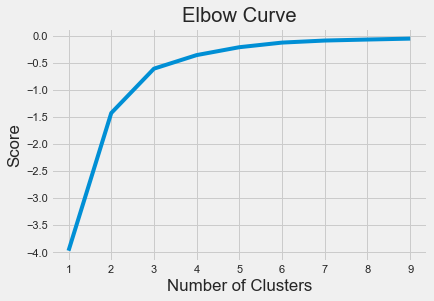

In [17]:
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = df_venues[['Venue Latitude']]
X_axis = df_venues[['Venue Longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]

plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [18]:
#Let's try using 4 clusters

kmeans = KMeans(n_clusters = 4, init ='k-means++')

kmeans.fit(X[X.columns[1:3]]) # Compute k-means clustering.

X['cluster_label'] = kmeans.fit_predict(X[X.columns[1:3]])

centers = kmeans.cluster_centers_ # Coordinates of cluster centers.

labels = kmeans.predict(X[X.columns[1:3]]) # Labels of each point
X.head()

Venue  Venue Latitude  Venue Longitude  \
0                    Sunglass Hut       47.705996      -122.325720   
1                    Sunglass Hut       47.705996      -122.325720   
2                        Claire's       47.705924      -122.325785   
3                            Lids       47.705924      -122.325785   
4  Duvall Massage and Acupuncture       47.631228      -122.342593   

   cluster_label  
0              0  
1              0  
2              0  
3              0  
4              2

<p>I opted for 4 clusters instead of the apparently recommended 3 because this venue data covers all of Seattle. It's better to break the city into slightly more journeys/regions that are feasible to navigate in one day, instead of 3 large regions that may go unexplored.</p>

<p>Next, we create a scatter plot of the venues by their coordinates. K-Means will then color-code the 4 different regions it creates.</p>

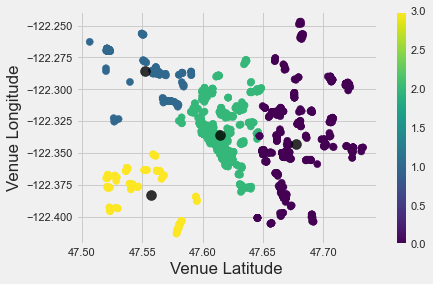

In [19]:
X.plot.scatter(x = 'Venue Latitude', y = 'Venue Longitude', c=labels, s=50, cmap='viridis')

plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.8)

<p>Before we combine our Feature List X with our Venues Data (to transfer the cluster_label column), we should drop the Location data or it will be added as duplicates.</p>

In [ ]:
X.drop(['Venue Latitude', 'Venue Longitude'], axis=1, inplace=True)

In [ ]:
#This section no longer needed since we saved the results to a CSV on GitHub
#We can now merge the data
#clustered_data = df_venues.merge(X, how='outer', left_index=True, right_index=True)
#clustered_data.info()

In [22]:
#And we should save this data to a CSV to avoid having to create it
#clustered_data.to_csv ('C:/Users/marko/Desktop/clustered_data.csv', index=None, header = True)

clustered_data = pd.read_csv('https://raw.githubusercontent.com/Mark-Olazabal/IBM-Capstone-Project/master/clustered_data.csv')

<p>Finally, we're ready to plot our venue regions and art works!</p>

In [23]:
latitude = 47.6219
longitude = -122.3517

colordict = {0:'#00a2ed', 1:'#33a02c', 2:'#1f78b4', 3:'#F25022'}

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

#Our clustered Venue Regions
for lat, lng, label, clust in zip(clustered_data['Venue Latitude'], clustered_data['Venue Longitude'], clustered_data['Venue_x'], clustered_data['cluster_label']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color=colordict[clust],
        fill=True,
        fill_color=colordict[clust],
        fill_opacity=0.5,
        parse_html=False).add_to(map_clusters)  

#Our Art Work data    
for a_lat, a_lng, a_label in zip(df_art['latitude'], df_art['longitude'], df_art['title']):
    a_label = folium.Popup(a_label, parse_html=True)
    folium.CircleMarker(
        [a_lat, a_lng],
        radius=3,
        popup=a_label,
        color='black',
        fill=True,
        fill_color='black',
        fill_opacity=0.5,
        parse_html=False).add_to(map_clusters)
    

map_clusters

<p>Looks like we've got our regions!</p>
<p>I have also added back in the art locations as smaller black markers. For tourists, these would be the points of interest to follow across the neighborhoods.</p>
<p>In order to turn this into actionable data for our business partnership recommendations, we'll need to export the regions to separate lists.</p>

In [30]:
#First, let's break up our venues data by cluster labels.
#Since we're using a static CSV, now, these numbers shouldn't have changed.

df_north_region = clustered_data[clustered_data['cluster_label'] == 2]
df_central_region = clustered_data[clustered_data['cluster_label'] == 3]
df_southwest_region = clustered_data[clustered_data['cluster_label'] == 0]
df_southeast_region = clustered_data[clustered_data['cluster_label'] == 1]


In [31]:
#Next, let's verify our lists by quickly mapping each region as a layer

latitude = 47.6219
longitude = -122.3517

#Let's make a few Feature Groups
fg_North = FeatureGroup(name = 'North Region')
fg_Central = FeatureGroup(name = 'Central Region')
fg_SWest = FeatureGroup(name = 'Southwest Region')
fg_SEast = FeatureGroup(name = 'Southeast Region')

#Color dictionary for use with cluster_label
colordict = {0:'gray', 1:'green', 2:'blue', 3:'orange'}

map_region_test = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, label, clust in zip(clustered_data['Venue Latitude'], clustered_data['Venue Longitude'], clustered_data['cluster_label'], clustered_data['cluster_label']):
    label = folium.Popup(label, parse_html=True)
    venue_marker = folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=colordict[clust],
        fill=True,
        fill_color=colordict[clust],
        fill_opacity=0.7,
        parse_html=False)
    if clust == 0:
        venue_marker.add_to(fg_SWest)
    elif clust == 1:
        venue_marker.add_to(fg_SEast)
    elif clust == 2:
        venue_marker.add_to(fg_North)
    elif clust == 3:
        venue_marker.add_to(fg_Central)
    else:
        print("No marker to add.")
        
        
fg_North.add_to(map_region_test)
fg_Central.add_to(map_region_test)
fg_SWest.add_to(map_region_test)
fg_SEast.add_to(map_region_test)

LayerControl().add_to(map_region_test)
map_region_test

<p>Excellent! By toggling the 4 Region Layers in the map above, we can verify that the 4 lists are correct. Now we can export them to CSVs for interested businesses.</p>

In [ ]:
#We no longer need to do this, as the files live in GitHub now, as well as in the Conclusion presentation.

#df_north_region.to_csv('C:/Users/marko/Desktop/North_Region.csv',index=False)
#df_central_region.to_csv('C:/Users/marko/Desktop/Central_Region.csv',index=False)
#df_southwest_region.to_csv('C:/Users/marko/Desktop/SWest_Region.csv',index=False)
#df_southeast_region.to_csv('C:/Users/marko/Desktop/SEast_Region.csv',index=False)

<a href="#backtotop">Back to Top</a>

<h2 style="color:#00a2ed">Results & Discussion</h2><a name="results"></a>

<p>Exploratory analysis revealed a few interesting metrics about our data. The highest concentration of public art and related venues was in the Downtown area: from Queen Anne Hill forming a straight line southeast to the International District through Belltown, Downtown, and Pioneer Square along the way. 
    
The majority of the associated venue categories we found were Coffee Shops: 159 out of 2225 venues. This isn't particularly surprising for Seattle.

After subjectively associating the venues with one of five "Super Categories" -- Food, Recreation, Retail, Service, or Hospitality -- we can see that Recreation tops the list at 859 out of 2225 venues. Food was a close second at 825 venues near public art.

Next, we were able to cluster the venues into four traversible regions: North, Central, Southwest and Southeast.</p>

<p>If we take the recommended daily steps of 10,000, that comes to about five miles. The four recommended tourist paths that connect the most dots in a 5-mile line are: (links will open in a new tab to Google Maps, walking directions)</p>

<ul>
    <li><a href="https://goo.gl/maps/gvkrzkUJWqFfmPGL6" target="_blank">North Region Walking Map - 4.9 miles</a></li>
    <li><a href="https://goo.gl/maps/9zYGCmqvSdEvsdTL7" target="_blank">Central Region Walking Map - 4.7 miles</a></li>
    <li><a href="https://goo.gl/maps/QaDj6UV512XYAzP77" target="_blank">Southwest Region Walking Map - 5.5 miles</a></li>
    <li><a href="https://goo.gl/maps/j98TgLLQ7QgUkLLMA" target="_blank">Southeast Region Walking Map - 3.8 miles</a></li>
        
</ul>

<p><b>Important note:</b> these are one of many, if not unlimited, paths across these regions. These are also one-way instructions. Please consult Google Maps for updated walking paths.</p>

<p>Finally, we were also able to produce four lists of venues in each of the four regions. Each list is a recommendation for partnerships within that list to offer discounts at partnering venues. Please see the presentation on the Conclusion for a summary/overview, the four lists as CSVs, and suggestions for application.</p>

<a href="#backtotop">Back to Top</a>

<h2 style="color:#00a2ed">Conclusion</h2><a name="conclusion"></a>

<p>The primary goal was to inform tourists and locals to support public art and their adjacent venues by using available data and analysis. We were able to collect, explore, and aggregate the venue and artwork data to cluster them into regions. Each region has a recommended walking path of approximately five miles that passes by the greatest number of art pieces. At each art piece, the tourist could decide to investigate one of the associated venues on the maps above. Those businesses, clustered around art works, could offer to make arrangements and discounts to invite additional business.</p>

<p>The following PowerPoint summarizes the outcomes and provides examples of how and when to use this data.</p>

<a href="https://github.com/Mark-Olazabal/IBM-Capstone-Project/blob/master/IBM_Capstone_Presentation.pptx" target="_blank">IBM & Coursera Capstone Project: Seattle Business Discount Partnerships Around Art [.PPT File]</a>

<a href="#backtotop">Back to Top</a>